In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helper_fun import *

In [5]:
import pickle

# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [6]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

Load the different splits

In [7]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [8]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

Create our initial model

In [9]:
from sklearn.neural_network import MLPClassifier

# Define the model
model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

Now we will train and test our model on the 4 different training splits we have created, we can then have a look at some performance metrics and think about how we can improve our model 

c:\Users\44747\anaconda3\envs\GroupAssignment1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<Figure size 800x600 with 0 Axes>

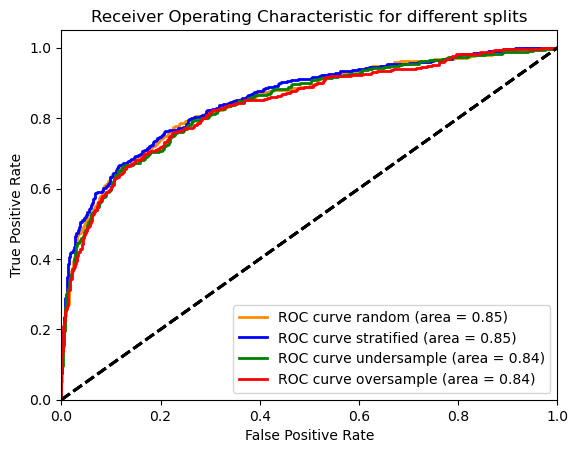

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

def evaluating_performance_diff_splits(model,split_data=split_data, adjust_threshold=False,threshold=0.5,display_confusion=True,display_roc=True, key_metric_only=False):
    performance = {}
    if display_confusion == True:
        #Create a 2x2 grid for confusion matrices
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
    if display_roc == True:
        plt.figure(figsize=(8,6))
        plt.figure()
    colors = ['darkorange', 'blue', 'green', 'red']
    # Loop through the splits in split_data
    for i, split in enumerate(split_data):
        X_train, X_val, y_train, y_val =split_data[split]
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict probabilities for the test set
        y_score = model.predict_proba(X_val)[:, 1]

        # Predict our target variable
        y_val_pred = model.predict(X_val)
        if adjust_threshold == True:
            y_val_pred = (y_score > threshold).astype(int)
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = auc(fpr, tpr)
        #Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        # Generate classification report
        report = classification_report(y_val, y_val_pred)
        # Extract metrics from classification report
        report_dict = classification_report(y_val, y_val_pred, output_dict=True)
        balanced_MCC = balanced_MCC_macro_avg(y_val, y_val_pred)
        
        if key_metric_only == False:
            performance[split] = {
                'precision': report_dict['1']['precision'],
                'recall': report_dict['1']['recall'],
                'f1-score': report_dict['1']['f1-score'],
                'support': report_dict['1']['support'],
                'roc_auc': roc_auc,
                'balanced_accuracy': balanced_acc,
                'balanced_MCC': balanced_MCC,
            }
        else:
            performance[split] = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }
        
        
        #Plot the confusion matrix for the teset set 
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        #Normalize the confusion matrix by the number of true samples per class
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        
        if display_confusion == True:
            sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i],
                        xticklabels=['Not Exited (0)', 'Exited (1)'],
                        yticklabels=['Not Exited (0)', 'Exited (1)'])
            axes[i].set_title(f'Confusion Matrix - {split} Split')
            axes[i].set_ylabel('Actual')
            axes[i].set_xlabel('Predicted')
            
        if display_roc == True:
            # Plot ROC curve
            plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve {split} (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic for different splits')
            plt.legend(loc="lower right")
    plt.show()
    performance = pd.DataFrame(performance).T
    return performance

performance_df = evaluating_performance_diff_splits(model=model,split_data=split_data,display_confusion=False, key_metric_only=True)

The ROC curves indicate a fairly good performance on all four of our splits.

Not here that the precison, recall and f1-score are based on the '1' class

In [21]:
performance_df

,recall,f1-score,balalanced_MCC
random,0.488024,0.585278,0.497590
stratified,0.521472,0.608229,0.522571
undersample,0.757485,0.576310,0.527669
oversample,0.706587,0.587796,0.525696


However, looking at our recall we can see when trained on the random split it is extremely low at 0.48 and 0.52 on stratified this is likely due to our imbalanced data and it not seeing a lot of positive (churns) in training. In our situation having a higher recall is important as we don't want to lose customers, we would rather have a lower precision and higher recall, which we see when trained on our undersampled and oversampled. We can also see from the heatmap that undersampling is giving us a lower percentage in the bottom left which is what we want.

In order to try and improve model performance I am going to try do some hyperparameter tuning, I will then return to look again at the model performance on each split.

I am going to start with a grid search using 10-fold cross validation on the random split, to maximise recall of the positive class.

In [9]:
from sklearn.metrics import make_scorer, recall_score, f1_score
# Define a custom scorer for recall of the positive class (class 1.0)
recall_scorer = make_scorer(recall_score, pos_label=1)
# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)


```python
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
X_train, X_val, y_train, y_val =split_data['random']

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring=recall_scorer, n_jobs=1, verbose=3,random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

And after my laptop nearly taking off... we should have some parameters that give us better recall.

In [ ]:
# Extract the best parameters from the grid search
best_params = grid_search.best_params_

# Create a new model with the best parameters
best_model = MLPClassifier(**best_params, max_iter=1000, random_state=42)

# Fit the model on the training data
best_model.fit(X_train, y_train)

In [ ]:
performance_GS_param = {}
evaluating_perfromance_diff_splits(model=best_model,split_data=split_data,performance_matrix=performance_GS_param)

In [ ]:
performance_GS_param_df = pd.DataFrame(performance_GS_param).T
performance_GS_param_df

Interesting we see here actually worse performance even though we used the grid search to try and find better parameters to maximise recall, maybe I didn't set the random seed correctly.

In [10]:
X_train, X_val, y_train, y_val = split_data['random']

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(randint(3, 128).rvs(), randint(3, 128).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=1, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.0061111501174320884, 'hidden_layer_sizes': (52, 55), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best recall score:  0.6089473489180234


In [14]:
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
print(best_params_random, best_score_random)

{'activation': 'relu', 'alpha': 0.0061111501174320884, 'hidden_layer_sizes': (52, 55), 'learning_rate': 'adaptive', 'solver': 'adam'} 0.6089473489180234


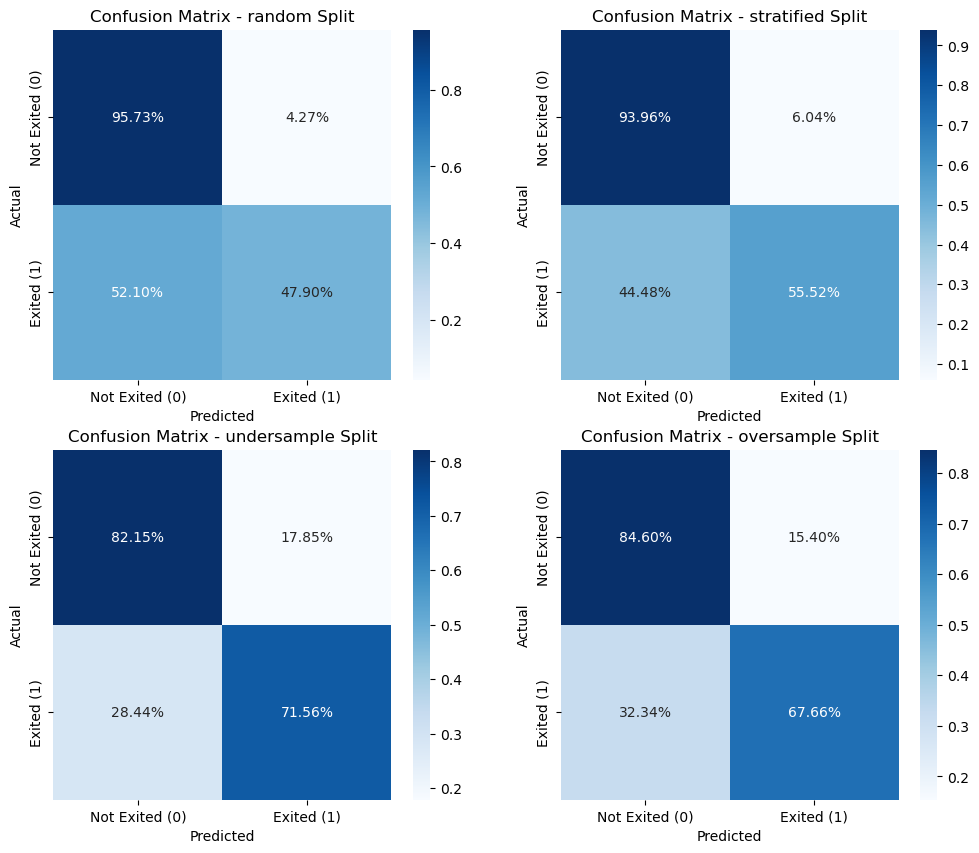

<Figure size 800x600 with 0 Axes>

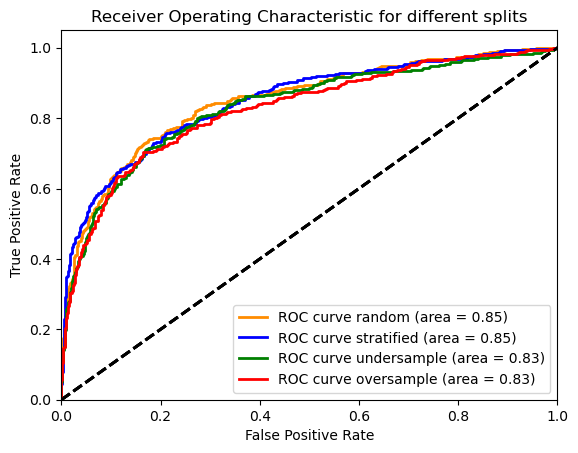

In [16]:
# Create a new model with the best parameters from the randomized search
best_model_RS = MLPClassifier(**best_params_random, max_iter=1000, random_state=42)
performance_RS = evaluating_performance_diff_splits(model=best_model_RS,split_data=split_data)

In [17]:
performance_RS

,precision,recall,f1-score,support,roc_auc,balanced_accuracy,balanced_MCC
random,0.747664,0.479042,0.583942,334.0,0.848363,0.718194,0.496915
stratified,0.701550,0.555215,0.619863,326.0,0.848564,0.747388,0.535941
undersample,0.513978,0.715569,0.598248,334.0,0.832007,0.768527,0.540092
oversample,0.536817,0.676647,0.598675,334.0,0.826220,0.761309,0.530275


Again getting worse after trying to fine-tune I might try run this in Google Colab to see if I see any improved performance, then import the new parameters from there into here.

### Bagging

We will do some bagging using our original model as hyper-parameter tuning hasn't been giving much success. Bagging will hopefully be a good choice as an ensemble method as our dataset is imbalanced and this could be a method to help improve performance despite this.

It has been used in medical scenaries to help improve performance where imbalanced data is common. 

I. Fakhruzi, "An artificial neural network with bagging to address imbalance datasets on clinical prediction," 2018 International Conference on Information and Communications Technology (ICOIACT), Yogyakarta, Indonesia, 2018, pp. 895-898, doi: 10.1109/ICOIACT.2018.8350824. keywords: {Bagging;Biological neural networks;Artificial neural networks;Classification algorithms;Data mining;Prediction algorithms;class imbalance problem;bagging;neural networks},



In [ ]:
from sklearn.ensemble import BaggingClassifier

# Define the model
model = MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Define the bagging classifier
bagging_model = BaggingClassifier(estimator=model, n_estimators=20, random_state=42)
performance_bagging = {}
evaluating_perfromance_diff_splits(model=bagging_model,split_data=split_data,performance_matrix=performance_bagging)

### Lowering our positive prediction threshold

I want to try and make my model more willing to predict a positive outcome (churn) as we have chosen recall as something that is important, we don't want any customers who might leave to not be incentivised to stay.

In [ ]:
# Create a new model with the best parameters from the randomized search
best_model_RS = MLPClassifier(**best_params_random, max_iter=1000, random_state=42)
performance_RS = {}
performance_RS = evaluating_perfromance_diff_splits(model=best_model_RS,split_data=split_data,performance_matrix=performance_RS,threshold=0.3,adjust_threshold=True)

In [ ]:
performance_RS_df = pd.DataFrame(performance_RS).T
performance_RS_df

We have a much better recall score now, but will have a look at choosing a more optimal threshold, to try and balance the performace of the metrics that are important to us.